# Altitude plots for Messier and NGC objects

Update IERS Bulletin A Earth Orientation Parameters from USNO if necessary.

In [1]:
from astroplan import download_IERS_A
download_IERS_A()

General imports

In [2]:
from datetime import datetime
import pytz as tz
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
months = mdates.MonthLocator()

import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import EarthLocation, SkyCoord
from astroplan import Observer, FixedTarget

In [3]:
%matplotlib inline

Function to generate an array of UTC julian dates at astronomical twilight every day for one year.

In [4]:
def ast_twi_rng(obs, time):
    begin = Time(time)
    dates = [begin + i*u.day for i in range(0,366)]
    ast_twi = []
    for date in dates:
        ast_twi.append(bb.twilight_evening_astronomical(date))
    return np.array(ast_twi)

Function to generate target from name.

In [5]:
def tgt_from_name(table, tgt):
    if table.meta['catalog'] == 'Messier':
        name, ra, dec, con, Type, ngc  = table.loc[tgt]['ID','RA','Dec', 'con', 'type', 'NGC/IC']
        return FixedTarget(coord=SkyCoord(ra, dec), name=f'{name} ({ngc}), {Type} in {con}')
    elif table.meta['catalog'] == 'NGC/IC':
        name, ra, dec, con, Type  = table.loc[tgt]['ID','RA','Dec', 'con', 'type']
        return FixedTarget(coord=SkyCoord(ra, dec), name=f'{name}, {Type} in {con}')

Function to generate a target list from a table

In [6]:
def tgt_list(table):
    if table.meta['catalog'] == 'Messier':
        return [FixedTarget(coord=SkyCoord(ra, dec), name=f'{name} ({ngc}), {Type} in {con}')
         for name, ra, dec, con, Type, ngc in table['ID','RA','Dec', 'con', 'type', 'NGC/IC']]
    elif table.meta['catalog'] == 'NGC/IC':
        return [FixedTarget(coord=SkyCoord(ra, dec), name=f'{name}, {Type} in {con}')
                for name, ra, dec, con, Type in table['ID','RA','Dec', 'con', 'type']]

Function to generate an altitude plot

In [7]:
def alt_plot(time_rng, tgt, save=''):
    obj = bb.altaz(time_rng, tgt)

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(list(obj.obstime.datetime), list(obj.alt.value), 'g')
    ax.set_title(tgt.name)
    ax.set_ylabel('altitude [deg]')
    ax.set_ylim(0,90)
    ax.set_xlim(datetime(2019, 1, 1), datetime(2020, 1, 1))
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.grid()
    if save !='':
        plt.savefig(save)

## Observer location and time

An observer can be initialized with a site from the astropy sites list. `EarthLocation.get_site_names()` will return a list of default observatories. Sites not in the default list can be defined using `EarthLocation.from_geodetic()`.

### Klee Mill, Sykesville, MD

In [8]:
loc_km = EarthLocation.from_geodetic(-76.989933*u.deg, 39.435108*u.deg, 197*u.m)
km = Observer(location=loc_km, name="Klee Mill, Sykesville, MD", timezone="US/Eastern")

### Bear Branch Observatory, Westminster, MD

In [9]:
# from Google Maps
loc = EarthLocation.from_geodetic(-76.986530*u.deg, 39.647191*u.deg, 210*u.m)
bb = Observer(location=loc, name="Bear Branch Observatory, Westminster, MD",
                       timezone="US/Eastern")

### Observation times

**UTC Date and Time for obervations**

In [10]:
time = Time('2019-05-09 01:00:00') # 2019-05-08 21:00:00 EDT
timeNow = Time.now() #current time

Set up the range times for Astronomical twilight.

In [11]:
ast_twilight_2019 = np.load('./data/bb_ast_twi_2019.npy', allow_pickle=True)

## Observation targets

### Messier Targets

In [12]:
# read in Messier targets from file
objects = np.genfromtxt('./data/messier', autostrip=True, delimiter=(6,14,16,7,6,9,5,6,10,40),
                             dtype=['<U4','<U12','<U14','<U5','<U4','<U9','<U3','<U4','<U8','<U40'])

In [13]:
# create Astropy Table from objects array
Messier = Table(objects, names=('ID','RA','Dec','epoch','mag','size','con','type',
                                'NGC/IC', 'comment'), meta={'catalog': 'Messier'})
Messier.add_index('ID')
# Messier.sort(keys='Dec')

In [14]:
# create target by name from table
name, ra, dec = Messier.loc['M3']['ID','RA','Dec']
M3 = FixedTarget(coord=SkyCoord(ra, dec), name=name)

In [15]:
M3 = tgt_from_name(Messier, 'M3'); M3

<FixedTarget "M3 (NGC 5272), GlCl in CVn" at SkyCoord (ICRS): (ra, dec) in deg (205.546775, 28.37545417)>

In [16]:
# create target list from table
messier_targets = [FixedTarget(coord=SkyCoord(ra, dec), name=name)
                   for name, ra, dec in Messier['ID','RA','Dec']]

In [17]:
messier_targets = tgt_list(Messier)

### RASC best NGC/IC

In [18]:
# read in RASC targets from file
objects = np.genfromtxt('./data/rasc', autostrip=True, delimiter=(10,10,9,6,10,5,7,45),
                             dtype=['<U8','<U8','<U7','<U4','<U8','<U3','<U5','<U45'])

In [19]:
RASC = Table(objects, names=('ID', 'RA', 'Dec', 'mag', 'size', 'con',
                             'type', 'comment'), meta={'catalog': 'NGC/IC'})
RASC.add_index('ID')
# RASC.sort(keys='Dec')

In [20]:
# create target by name from table
name, ra, dec = RASC.loc['NGC 7635']['ID','RA','Dec']
NGC7635 = FixedTarget(coord=SkyCoord(ra, dec), name=name)

In [21]:
NGC7635 = tgt_from_name(RASC, 'NGC 7635'); NGC7635

<FixedTarget "NGC 7635, EN in Cas" at SkyCoord (ICRS): (ra, dec) in deg (350.175, 61.2)>

In [22]:
# create target list from table
ngc_targets = [FixedTarget(coord=SkyCoord(ra, dec), name=name)
               for name, ra, dec in RASC['ID','RA','Dec']]

## Altitude plots

Shows target altitude at astronomical twilight for each day throughout the year

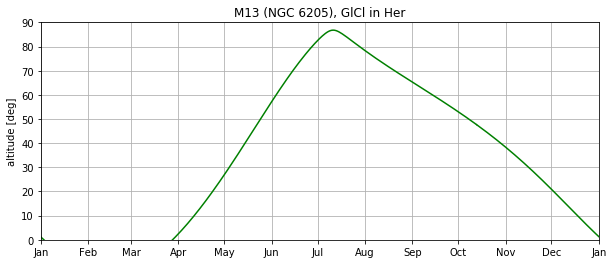

In [23]:
M13 = tgt_from_name(Messier, 'M13')
alt_plot(ast_twilight_2019, M13, save='./plots/M13_alt_2019.pdf')